# Illustration of experiments
These experiments are similar in nature to what we presented in our L4DC paper (results there are averaged across multiple seeds, and collected data in a different manner).
We compare a simple MLP to two variations of our differentiable and learnable robot model on simulated data.

In [1]:
import functools
import numpy as np
import torch
import random
import os
from tqdm import tqdm

from hydra.experimental import compose as hydra_compose
from hydra.experimental import initialize_config_dir

import diff_robot_data
from differentiable_robot_model import DifferentiableRobotModel
from differentiable_robot_model.data_utils import generate_sine_motion_inverse_dynamics_data
from differentiable_robot_model.rigid_body_params import (
    CovParameterized3DInertiaMatrixNet,
    PositiveScalar,
    UnconstrainedScalar,
    UnconstrainedTensor,
)
from torch.utils.data import DataLoader

torch.set_printoptions(precision=3, sci_mode=False)

random.seed(0)
np.random.seed(1) # seeds the data generation
torch.manual_seed(0)

/home/eacousineau/proj/tri/repo/externals/sys_id/differentiable-robot-model/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Normalized Mean-Squared Error Loss
class NMSELoss(torch.nn.Module):
    def __init__(self, var):
        super(NMSELoss, self).__init__()
        self.var = var
    def forward(self, yp, yt):
        err = (yp - yt)**2
        werr = err/self.var
        return werr.mean()

# Simple Multi-Layer Perceptron 
class SimpleMLP(torch.nn.Module):
    def __init__(self, in_dim, out_dim):
        super(SimpleMLP, self).__init__()
        self.in_dim = in_dim
        self.out_dim = out_dim
        self.layers = torch.nn.Sequential(
            torch.nn.Linear(self.in_dim, 250),
            torch.nn.ReLU(),
            torch.nn.Linear(250, 250),
            torch.nn.ReLU(),
            torch.nn.Linear(250, 100),
            torch.nn.ReLU(),
            torch.nn.Linear(100, self.out_dim),
        )

    def forward(self, q, qd, qdd_des):
        x = torch.cat([q, qd, qdd_des], dim=1)
        y = self.layers(x)
        return y

# Loading of Robot Model (kuka iiwa)

In [3]:
base_path = diff_robot_data.__path__[0]

urdf_path = os.path.join(base_path, "kuka_iiwa/urdf/iiwa7.urdf")
gt_robot_model = DifferentiableRobotModel(urdf_path, name="diff_robot_model_gt")

Unknown tag "material" in /robot[@name='iiwa7']/link[@name='iiwa_link_0']/collision[1]
Unknown tag "self_collision_checking" in /robot[@name='iiwa7']/link[@name='iiwa_link_0']
Unknown tag "material" in /robot[@name='iiwa7']/link[@name='iiwa_link_1']/collision[1]
Unknown tag "material" in /robot[@name='iiwa7']/link[@name='iiwa_link_2']/collision[1]
Unknown tag "material" in /robot[@name='iiwa7']/link[@name='iiwa_link_3']/collision[1]
Unknown tag "material" in /robot[@name='iiwa7']/link[@name='iiwa_link_4']/collision[1]
Unknown tag "material" in /robot[@name='iiwa7']/link[@name='iiwa_link_5']/collision[1]
Unknown tag "material" in /robot[@name='iiwa7']/link[@name='iiwa_link_6']/collision[1]
Unknown tag "material" in /robot[@name='iiwa7']/link[@name='iiwa_link_7']/collision[1]
Unknown tag "hardwareInterface" in /robot[@name='iiwa7']/transmission[@name='iiwa_tran_1']/actuator[@name='iiwa_motor_1']
Unknown tag "robotNamespace" in /robot[@name='iiwa7']/transmission[@name='iiwa_tran_1']
Unkno

In [4]:
# Set up for learning stuff.
learnable_links = [
    'iiwa_link_1', 'iiwa_link_2', 'iiwa_link_3', 'iiwa_link_4', 'iiwa_link_5',
    'iiwa_link_6', 'iiwa_link_7'
]
learnable_dynamics_paramertrizations = ['mass', 'inertia_mat']

def make_learnable(model, mass_paramertrization, inertia_parametrization):
    for link in learnable_links:
        model.make_link_param_learnable(
            link, "mass", mass_paramertrization()
        )
        model.make_link_param_learnable(
            link, "inertia_mat", inertia_parametrization()
        )

learnable_robot_unconstr = DifferentiableRobotModel(
    urdf_path, name="diffrnea_learnable_dynamics",
)
Unconstrained3DInertiaMatrix = functools.partial(
    UnconstrainedTensor, dim1=3, dim2=3
)
make_learnable(
    learnable_robot_unconstr,
    mass_paramertrization=UnconstrainedScalar,
    inertia_parametrization=Unconstrained3DInertiaMatrix,
)

learnable_robot_constr = DifferentiableRobotModel(
    urdf_path, name="learnable_dynamics_l4dc_structured",
)
make_learnable(
    learnable_robot_constr,
    mass_paramertrization=PositiveScalar,
    inertia_parametrization=CovParameterized3DInertiaMatrixNet,
)

Unknown tag "material" in /robot[@name='iiwa7']/link[@name='iiwa_link_0']/collision[1]
Unknown tag "self_collision_checking" in /robot[@name='iiwa7']/link[@name='iiwa_link_0']
Unknown tag "material" in /robot[@name='iiwa7']/link[@name='iiwa_link_1']/collision[1]
Unknown tag "material" in /robot[@name='iiwa7']/link[@name='iiwa_link_2']/collision[1]
Unknown tag "material" in /robot[@name='iiwa7']/link[@name='iiwa_link_3']/collision[1]
Unknown tag "material" in /robot[@name='iiwa7']/link[@name='iiwa_link_4']/collision[1]
Unknown tag "material" in /robot[@name='iiwa7']/link[@name='iiwa_link_5']/collision[1]
Unknown tag "material" in /robot[@name='iiwa7']/link[@name='iiwa_link_6']/collision[1]
Unknown tag "material" in /robot[@name='iiwa7']/link[@name='iiwa_link_7']/collision[1]
Unknown tag "hardwareInterface" in /robot[@name='iiwa7']/transmission[@name='iiwa_tran_1']/actuator[@name='iiwa_motor_1']
Unknown tag "robotNamespace" in /robot[@name='iiwa7']/transmission[@name='iiwa_tran_1']
Unkno

# Training
2 training routines for training the robot model, and for training a MLP

In [5]:

def train_robot_model(robot_model, train_data, test_data, lr, n_epochs, debug_print=False):
    train_loader = DataLoader(dataset=train_data, batch_size=256, shuffle=False)
    loss_fn = NMSELoss(train_data.var())
    opt = torch.optim.Adam(robot_model.parameters(), lr=1e-2)
    train_loss = []
    test_loss= []
    for i in range(50):
        losses = []
        for batch_idx, batch_data in enumerate(tqdm(train_loader)):
            q, qd, qdd_des, tau = batch_data
            opt.zero_grad()
            tau_pred = robot_model.compute_inverse_dynamics(q, qd, qdd_des)
            loss = loss_fn(tau_pred, tau)
            loss.backward()
            opt.step()
            losses.append(loss.item())
            
        train_loss.append(np.mean(losses))
        if debug_print:
            print("epoch: {}, loss: {}".format(i, train_loss[-1]))
        # test
        test_q, test_qd, test_qdd_des, test_tau = test_data.data['q'], test_data.data['qd'], test_data.data['qdd_des'], test_data.data['tau']
        test_tau_pred = robot_model.compute_inverse_dynamics(test_q, test_qd, test_qdd_des)
        test_loss.append(loss_fn(test_tau_pred, test_tau).item())
    return train_loss, test_loss

def train_mlp(model, train_data, test_data, lr, n_epochs, debug_print=False):
    train_loader = DataLoader(dataset=train_data, batch_size=256, shuffle=False)
    loss_fn = NMSELoss(train_data.var())
    opt = torch.optim.Adam(model.parameters(), lr=lr)
    train_loss = []
    test_loss= []
    for i in range(n_epochs):
        losses = []
        for batch_idx, batch_data in enumerate(tqdm(train_loader)):
            q, qd, qdd_des, tau = batch_data
            opt.zero_grad()
            tau_pred = model(q, qd, qdd_des)
            loss = loss_fn(tau_pred, tau)
            loss.backward()
            opt.step()
            losses.append(loss.item())
            
        train_loss.append(np.mean(losses))
        if debug_print:
            print("epoch: {}, loss: {}".format(i, train_loss[-1]))
        # test
        test_q, test_qd, test_qdd_des, test_tau = test_data.data['q'], test_data.data['qd'], test_data.data['qdd_des'], test_data.data['tau']
        test_tau_pred = model(test_q, test_qd, test_qdd_des)
        test_loss.append(loss_fn(test_tau_pred, test_tau).item())
    return train_loss, test_loss


# Data Generation
we use the ground truth robot model to generate training and test data. Here we generate data along a trajectory (sine motion trajectory) - which is how we would typically collect data on a real robot.

In [6]:
train_data = generate_sine_motion_inverse_dynamics_data(gt_robot_model, n_data=10000, dt=1.0/250.0, freq=0.1)
test_data = generate_sine_motion_inverse_dynamics_data(gt_robot_model, n_data=10000, dt=1.0/250.0, freq=0.2)

# Training
We now train all 3 models (MLP, robot model without physical constraints and robot model with physical constraints)

In [7]:
# the mlp seems to train better with lr=1e-3 (while for robot models we use 1e-2)
simple_mlp = SimpleMLP(in_dim=21, out_dim=7)
train_loss_mlp, test_loss_mlp = train_mlp(simple_mlp, train_data, test_data, lr=1e-3, n_epochs=50)

100%|██████████| 40/40 [00:00<00:00, 80.62it/s]


In [8]:
train_loss_unconstr, test_loss_unconstr = train_robot_model(learnable_robot_unconstr, train_data, test_data, lr=1e-2, n_epochs=50)

100%|██████████| 40/40 [00:02<00:00, 14.18it/s]


In [9]:
train_loss_constr, test_loss_constr = train_robot_model(learnable_robot_constr, train_data, test_data, lr=1e-2, n_epochs=50)

100%|██████████| 40/40 [00:03<00:00, 11.17it/s]


# Results
The learnable (structured) robot models outperform the simple mlp in generalizing to test data. The robot model with physical constraints on the parameters performs best.

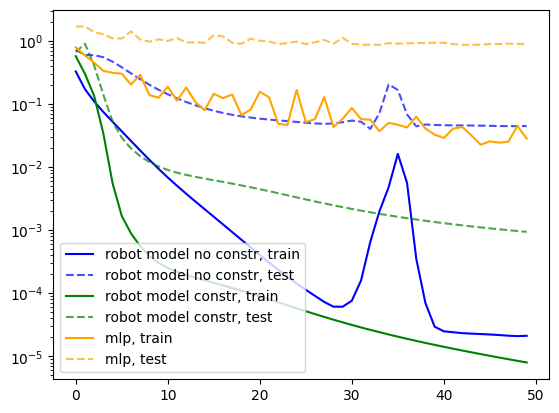

In [11]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.semilogy(train_loss_unconstr, color='blue', label='robot model no constr, train')
plt.semilogy(test_loss_unconstr, color='blue', linestyle='--', alpha=0.7, label='robot model no constr, test')
plt.semilogy(train_loss_constr, color='green', label='robot model constr, train')
plt.semilogy(test_loss_constr, color='green', linestyle='--',alpha=0.7, label='robot model constr, test')
plt.semilogy(train_loss_mlp, color='orange', label='mlp, train')
plt.semilogy(test_loss_mlp, color='orange', linestyle='--',alpha=0.7, label='mlp, test')
plt.legend()